# Model intepretation

In [ ]:
#uncomment this below code to install imblearn package
# !pip install imbalanced-learn

In [ ]:
# !pip install scikit-optimize
# !pip install lime

In [2]:
import pandas as pd
import numpy as np
import sklearn
import shap
# import lime

#statistics
from scipy.stats import chi2_contingency, ttest_ind

# import cudf #gpu-powered DataFrame (Pandas alternative)

#imbalance handling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, RepeatedEditedNearestNeighbours
from imblearn.pipeline import Pipeline

#preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split

#hyperparameter search
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize

#internal validation
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedStratifiedKFold, cross_val_score, GridSearchCV, PredefinedSplit, RandomizedSearchCV


#performance metrices
from sklearn.metrics import precision_recall_curve, make_scorer, confusion_matrix, classification_report, f1_score, balanced_accuracy_score, r2_score, auc, average_precision_score, roc_auc_score, recall_score, roc_curve, accuracy_score

#Models selection
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
# from cuml.svm import SVC #gpu-powered SVM


#save and load trained model
import pickle

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

import os

random_state = 42

ImportError: Numba needs NumPy 1.24 or less

In [5]:
gridSearchData, crossValData, internalEvaluationData, externalEvaluationData = pickle.load(open('../../Clean_data/dataset_scaled_ordinal_24062025.sav', 'rb'))
# features = pd.read_csv('../../Clean_data/data_features_2vs1_2016-2018_21102024.csv', low_memory=False)

In [6]:
#Define feature candidates

features_columns = gridSearchData.columns.to_list()
exclude_columns = ['patid', 'practice_id', 'set', #identifier
                   'BMI', #use the categorical instead
                   'ethnicity', #use ethnic_group instead
                   'Spacer',  #all zero
                   'asthmaPlan', #use the continuous one
                   
                   'outcome_3months', 'outcome_6months', 'outcome_9months', 'outcome_12months', 'outcome_15months', 'outcome_18months', 
                   'outcome_21months', 'outcome_24months', 'outcome_combined_6months', 'outcome_combined_9months', 'outcome_combined_12months', 
                   'outcome_combined_15months', 'outcome_combined_18months', 'outcome_combined_24months', '3months', '6months', '12months', '24months', #outcomes variable
                   
                   'postcode_district', 'County', 'LocalAuthority', 'OutputAreaClassification', #location related variables, use IMD decile only
                   
                   'age_cat', 'ICS_medication_possesion_ratio_cat', 'numOCS_cat', 'numOCSEvents_cat', 'numOCSwithLRTI_cat', 'numAcuteRespEvents_cat', 
                   'numAntibioticsEvents_cat', 'numAntibioticswithLRTI_cat', 'numAsthmaAttacks_cat', 'numHospEvents_cat', 'numPCS_cat', 'numPCSAsthma_cat', 
                   'numAsthmaManagement_cat', 'numAsthmaReview_cat', 'numAsthmaMedReview_cat', 'numAsthmaReviewRCP_cat', 'average_daily_dose_ICS_cat', 
                   'prescribed_daily_dose_ICS_cat', #use continous vars instead
                   
                   'count_rhinitis', 'count_cardiovascular', 'count_heartfailure',
                   'count_psoriasis', 'count_anaphylaxis', 'count_diabetes', 'count_ihd',
                   'count_anxiety', 'count_eczema', 'count_nasalpolyps',
                   'count_paracetamol', 'count_nsaids', 'count_betablocker', #use binary ones
                   
                   'paracetamol', 'nsaids', 'betablocker', #no data in evaluation
                   'numAsthmaMedReview', 'numAsthmaReviewRCP',
                                      
                  ]
# exclude_columns = exclude_columns + [x for x in features_columns if '_count' in x] #filter out commorbid count variables
features_columns = [x for x in features_columns if x not in exclude_columns]
print('Features size: ', len(features_columns))
print(features_columns)

Features size:  48
['sex', 'rhinitis', 'cardiovascular', 'heartfailure', 'psoriasis', 'anaphylaxis', 'diabetes', 'ihd', 'anxiety', 'eczema', 'nasalpolyps', 'ethnic_group_Asian', 'ethnic_group_Black', 'ethnic_group_Mixed', 'ethnic_group_Other', 'ethnic_group_White', 'ethnic_group_not recorded', 'smokingStatus_current', 'smokingStatus_former', 'smokingStatus_never', 'DeviceType_BAI', 'DeviceType_DPI', 'DeviceType_NEB', 'DeviceType_not recorded', 'DeviceType_pMDI', 'PriorEducation_No', 'PriorEducation_Yes', 'age', 'average_daily_dose_ICS', 'prescribed_daily_dose_ICS', 'ICS_medication_possesion_ratio', 'numPCS', 'numPCSAsthma', 'numAntibioticsEvents', 'numAntibioticswithLRTI', 'numOCSEvents', 'numOCSwithLRTI', 'numAsthmaAttacks', 'numAcuteRespEvents', 'numHospEvents', 'numAsthmaManagement', 'numAsthmaReview', 'imd_decile', 'CharlsonScore', 'BTS_step', 'BMI_cat', 'PEFStatus', 'EosinophilLevel']


In [7]:
X = crossValData[features_columns]
X_internalVal = internalEvaluationData[features_columns]
X_externalVal = externalEvaluationData[features_columns]
y_externalVal = externalEvaluationData[['outcome_12months']]

print(X.shape)
print(X_internalVal.shape)
print(X_externalVal.shape)


target_outcomes = [
    'outcome_3months', 'outcome_6months', 'outcome_9months', 
    'outcome_12months',
] 
# target_outcomes = ['12months'] 
model_names = [
    'LR', 'Lasso', 'ElasticNet', 
    'DT', 'RF', 
    'XGB'
              ]

(440477, 48)
(120641, 48)
(19820, 48)


In [5]:
data = pd.read_csv('../../MODELS/externalValResult_ordinal.csv')

Text(0.5, 21.70624999999974, 'Method')

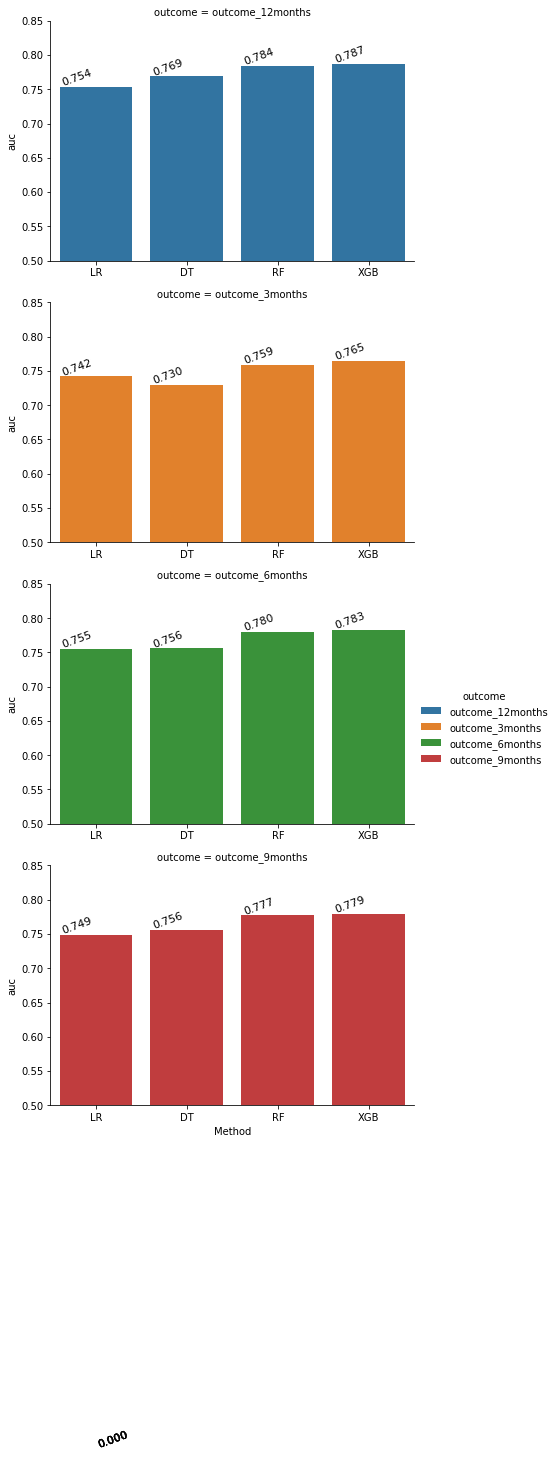

In [6]:
#PLOT
# data = combine
# data = combine[(combine.outcome=='outcome_12months')]
data = data[data.model_name!='ElasticNet']
bar = sns.catplot(x = 'model_name',       # x variable name
            y = 'auc',       # y variable name            
            data=data,
            kind = "bar",
            hue = 'outcome',
            # hue_order=['10-fold CV', 'Evaluation Set', 'Wales', 'Scotland'],
            height=4,
            row='outcome',
            aspect=1.5,
            errorbar = None, sharex=False)

for items in bar.axes:
    for ax in items:
        for p in ax.patches:
            ax.text(p.get_x() + 0.01, 
                p.get_height() * 1.002, 
                '{0:.3f}'.format(p.get_height()), 
                color='black', rotation=20, fontsize=11)

ax.set_ylim(0.5, .85)
# ax.set_ylabel('AUC Score', fontsize=13)
ax.set_xlabel('Method', fontsize=10)
# ax.set_xticklabels(fontsize=20)

(0.5, 0.85)

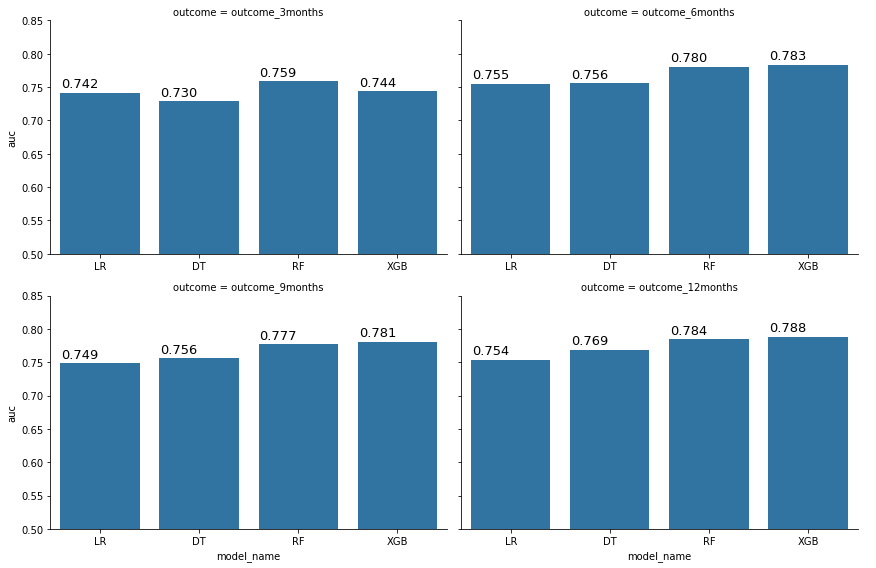

In [67]:
#PLOT
# data = combine
# data = combine[(combine.outcome=='outcome_12months')]
# data = summary_result_externalVal
bar = sns.catplot(x = 'model_name',       # x variable name
            y = 'auc',       # y variable name            
            data=data,
            kind = "bar",
            # hue = 'outcome',
            # hue_order=['10-fold CV', 'Evaluation Set', 'Wales', 'Scotland'],
            height=4,
            col='outcome',
                  col_order=['outcome_3months', 'outcome_6months', 'outcome_9months', 'outcome_12months'],
              # col='model_name',
            aspect=1.5,
                  sharex=False,
                  col_wrap=2,
                  
            )

for ax in bar.axes:
    # for ax in items:
        for p in ax.patches:
            ax.text(p.get_x() + 0.01, 
                p.get_height() * 1.01, 
                '{0:.3f}'.format(p.get_height()), 
                color='black', rotation=0, fontsize=13)

ax.set_ylim(0.5, .85)
# ax.set_ylabel('AUC Score', fontsize=13)
# ax.set_xlabel('Method', fontsize=10)
# ax.set_xticklabels(fontsize=20)

(0.0, 0.5)

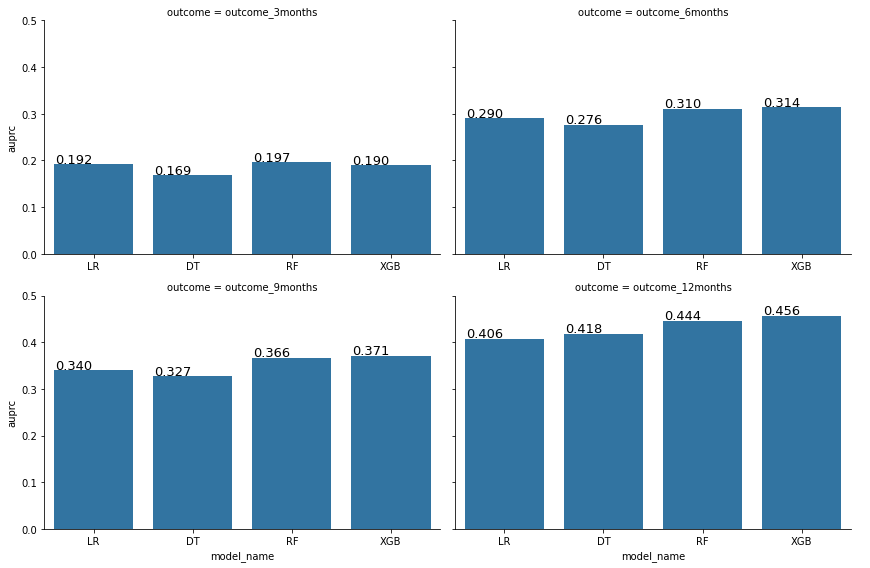

In [74]:
#PLOT
# data = combine
# data = combine[(combine.outcome=='outcome_12months')]
# data = summary_result_externalVal
bar = sns.catplot(x = 'model_name',       # x variable name
            y = 'auprc',       # y variable name            
            data=data,
            kind = "bar",
            # hue = 'auc',
            # hue_order=['10-fold CV', 'Evaluation Set', 'Wales', 'Scotland'],
            height=4,
            col='outcome',
                  col_order=['outcome_3months', 'outcome_6months', 'outcome_9months', 'outcome_12months'],
              # col='model_name',
            aspect=1.5,
                  sharex=False,
                  col_wrap=2,
                  
            )

for ax in bar.axes:
    # for ax in items:
        for p in ax.patches:
            ax.text(p.get_x() + 0.01, 
                p.get_height() * 1.01, 
                '{0:.3f}'.format(p.get_height()), 
                color='black', rotation=0, fontsize=13)

ax.set_ylim(0, .5)
# ax.set_ylabel('AUC Score', fontsize=13)
# ax.set_xlabel('Method', fontsize=10)
# ax.set_xticklabels(fontsize=20)

Text(0.5, 21.706249999999997, 'Method')

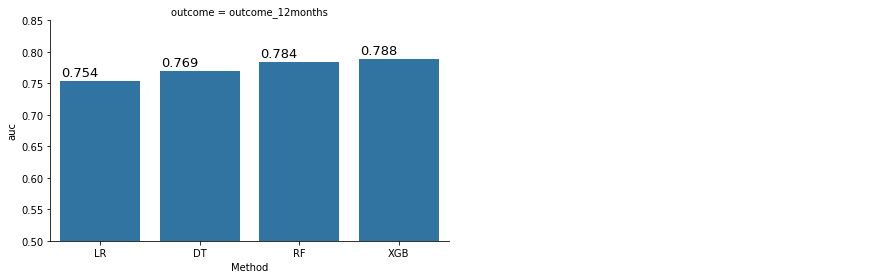

In [16]:
#PLOT

bar = sns.catplot(x = 'model_name',       # x variable name
            y = 'auc',       # y variable name            
            data=data[(data.outcome=='outcome_12months')],
            kind = "bar",
            # hue = 'outcome',
            # hue_order=['10-fold CV', 'Evaluation Set', 'Wales', 'Scotland'],
            height=4,
            col='outcome',
              # col='model_name',
            aspect=1.5,
                  col_wrap=2,
            errorbar = None, sharex=False)

for ax in bar.axes:
    # for ax in items:
        for p in ax.patches:
            ax.text(p.get_x() + 0.01, 
                p.get_height() * 1.01, 
                '{0:.3f}'.format(p.get_height()), 
                color='black', rotation=0, fontsize=13)

ax.set_ylim(0.5, .85)
# ax.set_ylabel('AUC Score', fontsize=13)
ax.set_xlabel('Method', fontsize=10)
# ax.set_xticklabels(fontsize=20)

## AUC PLOT

In [8]:
#3months
lr_model = pickle.load(open('../../MODELS/TestResultOrdinal/outcome_3months_LR.sav', 'rb'))
dt_model = pickle.load(open('../../MODELS/TestResultOrdinal/outcome_3months_DT.sav', 'rb'))
rf_model = pickle.load(open('../../MODELS/TestResultOrdinal/outcome_3months_RF.sav', 'rb'))
xgb_model = pickle.load(open('../../MODELS/TestResultOrdinal/outcome_3months_XGB.sav', 'rb'))
# Calculate ROC curve
plt.figure(figsize=(10,7))

#LR model
preds2 = lr_model.predict_proba(X_externalVal)
preds2 = [x[1] for x in preds2]
fpr2, tpr2, thresholds2 = roc_curve(y_externalVal.values, preds2) 
roc_auc2 = auc(fpr2, tpr2)
plt.plot(fpr2, tpr2, label='LR (auc = %0.3f)' % roc_auc2)

#dt model
preds3 = dt_model.predict_proba(X_externalVal)
preds3 = [x[1] for x in preds3]
fpr3, tpr3, thresholds3 = roc_curve(y_externalVal.values, preds3) 
roc_auc3 = auc(fpr3, tpr3)
plt.plot(fpr3, tpr3, label='DT (auc = %0.3f)' % roc_auc3)

#rf model
preds4 = rf_model.predict_proba(X_externalVal)
preds4 = [x[1] for x in preds4]
fpr4, tpr4, thresholds4 = roc_curve(y_externalVal.values, preds4) 
roc_auc4 = auc(fpr4, tpr4)
plt.plot(fpr4, tpr4, label='RF (auc = %0.3f)' % roc_auc4)

#XGBoost all
preds5 = xgb_model.predict_proba(X_externalVal)
preds5 = [x[1] for x in preds5]
fpr5, tpr5, thresholds5 = roc_curve(y_externalVal.values, preds5) 
roc_auc5 = auc(fpr5, tpr5)
plt.plot(fpr5, tpr5, label='XGB (auc = %0.3f)' % roc_auc5)


plt.plot([0, 1], [0, 1], 'k--', label='Random prediction')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

/home/abudiarto/enter/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.5.1 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ValueError: node array from the pickle has an incompatible dtype:
- expected: [('left_child', '<i8'), ('right_child', '<i8'), ('feature', '<i8'), ('threshold', '<f8'), ('impurity', '<f8'), ('n_node_samples', '<i8'), ('weighted_n_node_samples', '<f8')]
- got     : {'names': ['left_child', 'right_child', 'feature', 'threshold', 'impurity', 'n_node_samples', 'weighted_n_node_samples', 'missing_go_to_left'], 'formats': ['<i8', '<i8', '<i8', '<f8', '<f8', '<i8', '<f8', 'u1'], 'offsets': [0, 8, 16, 24, 32, 40, 48, 56], 'itemsize': 64}

In [77]:
lr_model = pickle.load(open('../../MODELS/TestResultOrdinal/outcome_12months_LR.sav', 'rb'))
dt_model = pickle.load(open('../../MODELS/TestResultOrdinal/outcome_12months_DT.sav', 'rb'))
rf_model = pickle.load(open('../../MODELS/TestResultOrdinal/outcome_12months_RF.sav', 'rb'))
xgb_model = pickle.load(open('../../MODELS/TestResultOrdinal/outcome_12months_XGB.sav', 'rb'))

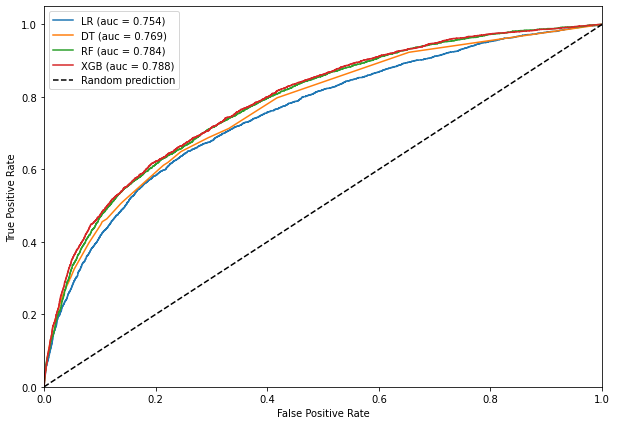

In [81]:
# Calculate ROC curve
plt.figure(figsize=(10,7))

#LR model
preds2 = lr_model.predict_proba(X_externalVal)
preds2 = [x[1] for x in preds2]
fpr2, tpr2, thresholds2 = roc_curve(y_externalVal.values, preds2) 
roc_auc2 = auc(fpr2, tpr2)
plt.plot(fpr2, tpr2, label='LR (auc = %0.3f)' % roc_auc2)

#dt model
preds3 = dt_model.predict_proba(X_externalVal)
preds3 = [x[1] for x in preds3]
fpr3, tpr3, thresholds3 = roc_curve(y_externalVal.values, preds3) 
roc_auc3 = auc(fpr3, tpr3)
plt.plot(fpr3, tpr3, label='DT (auc = %0.3f)' % roc_auc3)

#rf model
preds4 = rf_model.predict_proba(X_externalVal)
preds4 = [x[1] for x in preds4]
fpr4, tpr4, thresholds4 = roc_curve(y_externalVal.values, preds4) 
roc_auc4 = auc(fpr4, tpr4)
plt.plot(fpr4, tpr4, label='RF (auc = %0.3f)' % roc_auc4)

#XGBoost all
preds5 = xgb_model.predict_proba(X_externalVal)
preds5 = [x[1] for x in preds5]
fpr5, tpr5, thresholds5 = roc_curve(y_externalVal.values, preds5) 
roc_auc5 = auc(fpr5, tpr5)
plt.plot(fpr5, tpr5, label='XGB (auc = %0.3f)' % roc_auc5)


plt.plot([0, 1], [0, 1], 'k--', label='Random prediction')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

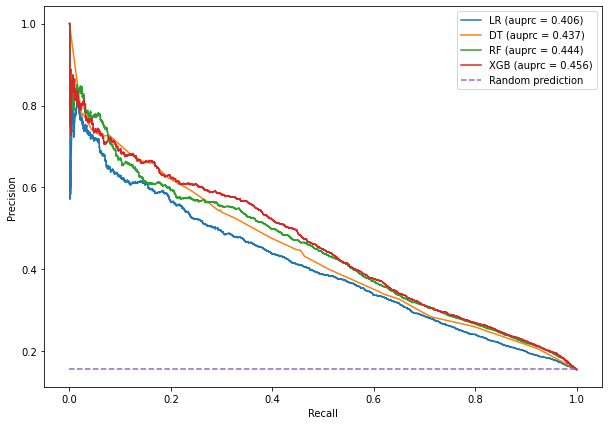

In [36]:
# plot the precision-recall curves
plt.figure(figsize=(10,7))
#LR
lr_precision, lr_recall, lr_thresholds = precision_recall_curve(y_externalVal, preds2)
lr_auprc = auc(lr_recall, lr_precision)
plt.plot(lr_recall, lr_precision, label='LR (auprc = %0.3f)' % lr_auprc)

#DT
dt_precision, dt_recall, dt_thresholds = precision_recall_curve(y_externalVal, preds3)
dt_auprc = auc(dt_recall, dt_precision)
plt.plot(dt_recall, dt_precision, label='DT (auprc = %0.3f)' % dt_auprc)

#RF
rf_precision, rf_recall, rf_thresholds = precision_recall_curve(y_externalVal, preds4)
rf_auprc = auc(rf_recall, rf_precision)
plt.plot(rf_recall, rf_precision, label='RF (auprc = %0.3f)' % rf_auprc)

#XGB
xgb_precision, xgb_recall, xgb_thresholds = precision_recall_curve(y_externalVal, preds5)
xgb_auprc = auc(xgb_recall, xgb_precision)
plt.plot(xgb_recall, xgb_precision, label='XGB (auprc = %0.3f)' % xgb_auprc)


no_skill = len(y_externalVal[y_externalVal.outcome_12months==1]) / len(y_externalVal)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Random prediction')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [40]:
y_externalVal['outcome_12months'].value_counts(normalize=True)

outcome_12months
0    0.844159
1    0.155841
Name: proportion, dtype: float64

# Feature importance

In [17]:
var_names_fix = [
    'Sex', 
    'Comorbidities - rhinitis',
    'Comorbidities - cardiovascular',
    'Comorbidities - heart failure',
    'Comorbidities - psoriasis',
    'Comorbidities - anaphilaxis',
    'Comorbidities - diabetes',
    'Comorbidities - ischaemic heart disease',
    'Comorbidities - anxiety',
    'Comorbidities - eczema',
    'Comorbidities - nasalpolyps',
    'Ethnicity - Asian', 
    'Ethnicity - Black', 
    'Ethnicity - Mixed',
    'Ethnicity - Other', 
    'Ethnicity - White', 
    'Ethnicity - Not recorded', 
    'Smoking status', 
    'Smoking status', 
    'Smoking status', 
    'ICS device type - BAI',
    'ICS device type - DPI',
    'ICS device type - NEB',
    'ICS device type - Not recorded',
    'ICS device type - pMDI',
    'No prior asthma education recorded', 
    'Prior asthma education recorded', 
    'Age', 
    'Average daily dose of ICS', 
    'Last prescribed daily dose of ICS', 
    'ICS medication possession ratio', 
    'Number of primary care consultations', 
    'Number of asthma-related primary care consultations', 
    'Number of antibiotics courses', 
    'Number of antibiotics courses with LRTI', 
    'Number of OCS courses', 
    'Number of OCS courses with LRTI', 
    'Number of previous asthma attacks', 
    'Number of acute respiratory events', 
    'Number of hospital attendance/admission', 
    'Number of previous asthma mangement plan given',
    'Number of previous asthma annual review',
    'Index of multiple deprivation',
    'Charlson comorbidity index',
    'BTS step',
    'BMI_cat',
    '% predicted PEF',
    'Blood eosinophil count',   
]
var_names_fix = np.array(var_names_fix)

In [10]:
X.columns.values.shape

(48,)

In [18]:
var_names_fix.shape

(48,)

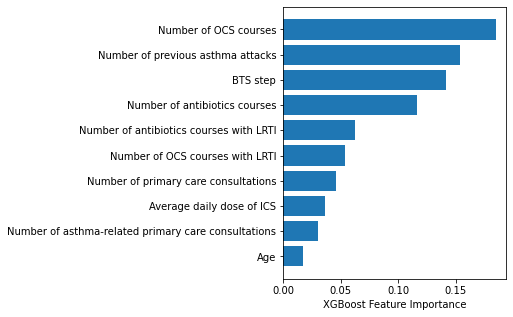

In [19]:
best_model_dt = pickle.load(open('../../MODELS/TestResultOrdinal/outcome_12months_XGB.sav', 'rb'))

# pd.DataFrame([best_model3.feature_importances_], columns=X.columns).T.sort_values(0, ascending=False)
sorted_idx = best_model_dt.feature_importances_.argsort()
plt.figure(figsize=(4,5))
plt.barh(var_names_fix[sorted_idx][-10:], best_model_dt.feature_importances_[sorted_idx][-10:])
plt.xlabel("XGBoost Feature Importance")
plt.show()
dttop10 = X.columns[sorted_idx][-10:]

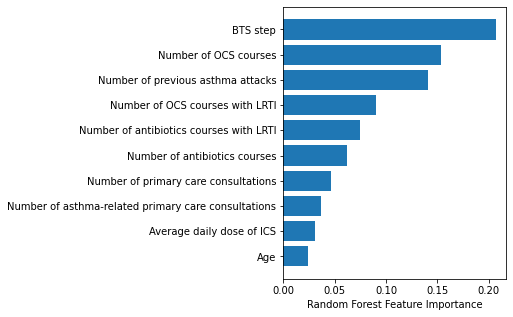

In [24]:
best_model_dt = pickle.load(open('../../MODELS/TestResultOrdinal/outcome_12months_RF.sav', 'rb'))

# pd.DataFrame([best_model3.feature_importances_], columns=X.columns).T.sort_values(0, ascending=False)
sorted_idx = best_model_dt.feature_importances_.argsort()
plt.figure(figsize=(4,5))
plt.barh(var_names_fix[sorted_idx][-10:], best_model_dt.feature_importances_[sorted_idx][-10:])
plt.xlabel("Random Forest Feature Importance")
plt.show()
dttop10 = X.columns[sorted_idx][-10:]

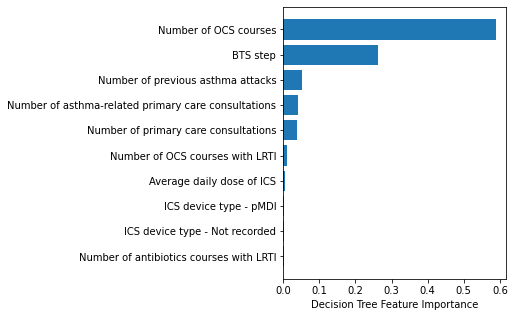

In [25]:
best_model_dt = pickle.load(open('../../MODELS/TestResultOrdinal/outcome_12months_DT.sav', 'rb'))

# pd.DataFrame([best_model3.feature_importances_], columns=X.columns).T.sort_values(0, ascending=False)
sorted_idx = best_model_dt.feature_importances_.argsort()
plt.figure(figsize=(4,5))
plt.barh(var_names_fix[sorted_idx][-10:], best_model_dt.feature_importances_[sorted_idx][-10:])
plt.xlabel("Decision Tree Feature Importance")
plt.show()
dttop10 = X.columns[sorted_idx][-10:]

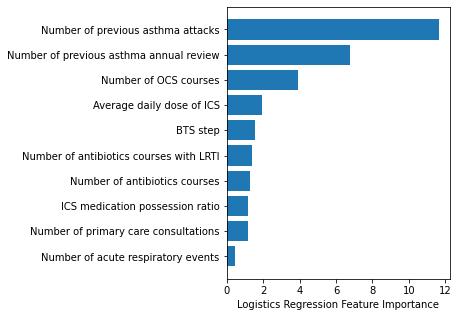

In [26]:
best_model_dt = pickle.load(open('../../MODELS/TestResultOrdinal/outcome_12months_LR.sav', 'rb'))

# pd.DataFrame([best_model3.feature_importances_], columns=X.columns).T.sort_values(0, ascending=False)
sorted_idx = best_model_dt.coef_[0].argsort()
plt.figure(figsize=(4,5))
plt.barh(var_names_fix[sorted_idx][-10:], best_model_dt.coef_[0][sorted_idx][-10:])
plt.xlabel("Logistics Regression Feature Importance")
plt.show()
dttop10 = X.columns[sorted_idx][-10:]

In [ ]:
# best_model_dt.feature_importances_[sorted_idx][-30:]

## SHAP

In [7]:
gridSearchDataOri, crossValDataOri, internalEvaluationDataOri, externalEvaluationDataOri = pickle.load(open('../../Clean_data/dataset_onehotencoded_ordinalversion.sav', 'rb'))
# features = pd.read_csv('../../Clean_data/data_features_2vs1_2016-2018_21102024.csv', low_memory=False)

In [8]:
# X = crossValData[features_columns]
# X_internalVal = internalEvaluationData[features_columns]
X_externalVal_Ori = externalEvaluationDataOri[features_columns]
y_externalVal_Ori = externalEvaluationDataOri[['outcome_12months']]

print(y_externalVal_Ori.shape)
print(X_externalVal_Ori.shape)


target_outcomes = [
    'outcome_3months', 'outcome_6months', 'outcome_9months', 
    'outcome_12months',
] 
# target_outcomes = ['12months'] 
model_names = [
    'LR', 'Lasso', 'ElasticNet', 
    'DT', 'RF', 
    'XGB'
              ]

(19860, 1)
(19860, 48)


In [44]:
# Load the model from the saved binary file
model = pickle.load(open('../../MODELS/TestResultOrdinal/outcome_12months_XGB.sav', 'rb'))

# SHAP Explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_externalVal)

In [45]:
# Initialize the SHAP JavaScript library
shap.initjs()

In [46]:
preds = model.predict(X_externalVal)
y_externalVal['preds'] = preds

/tmp/ipykernel_212/2936894604.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_externalVal['preds'] = preds


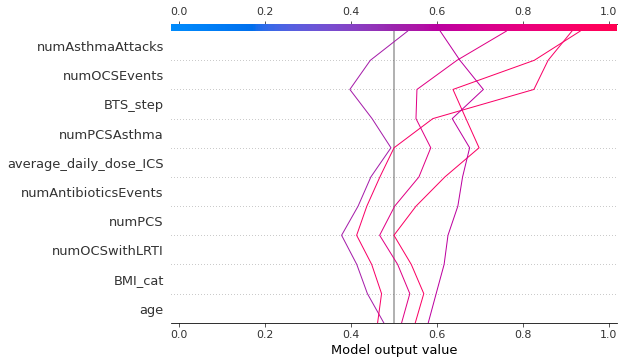

In [47]:
sample_id = y_externalVal[(y_externalVal.outcome_12months==1)&(y_externalVal.preds==1)].index[:5].tolist()
# shap.summary_plot(shap_values, X_externalVal_Ori, feature_names=X_externalVal.columns)
shap.decision_plot(explainer.expected_value, 
                   shap_values.values[sample_id], 
                   features = X_externalVal_Ori.iloc[sample_id], 
                   feature_display_range=slice(-1, -11, -1), 
                   link="logit", )
# shap.force_plot(explainer.expected_value, shap_values.values[sample_id], X_externalVal_Ori.iloc[sample_id], matplotlib=True)

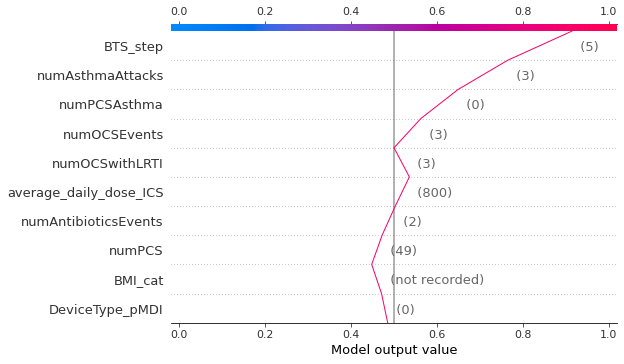

In [48]:
#TP
sample_id = 54
# shap.summary_plot(shap_values, X_externalVal_Ori, feature_names=X_externalVal.columns)
shap.decision_plot(explainer.expected_value, 
                   shap_values.values[sample_id], 
                   features = X_externalVal_Ori.iloc[sample_id], 
                   feature_display_range=slice(-1, -11, -1), 
                   link="logit", )
shap.force_plot(explainer.expected_value, shap_values.values[sample_id], X_externalVal_Ori.iloc[sample_id], link="logit")

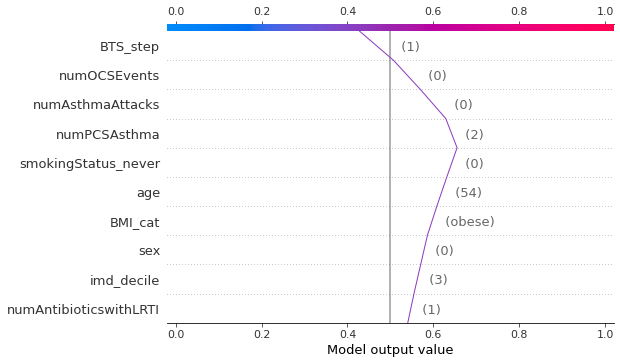

In [49]:
#FN
sample_id = 98
# shap.summary_plot(shap_values, X_externalVal_Ori, feature_names=X_externalVal.columns)
shap.decision_plot(explainer.expected_value, 
                   shap_values.values[sample_id], 
                   features = X_externalVal_Ori.iloc[sample_id], 
                   feature_display_range=slice(-1, -11, -1), #descending order
                   link="logit", )
shap.force_plot(explainer.expected_value, shap_values.values[sample_id], X_externalVal_Ori.iloc[sample_id], link='logit')

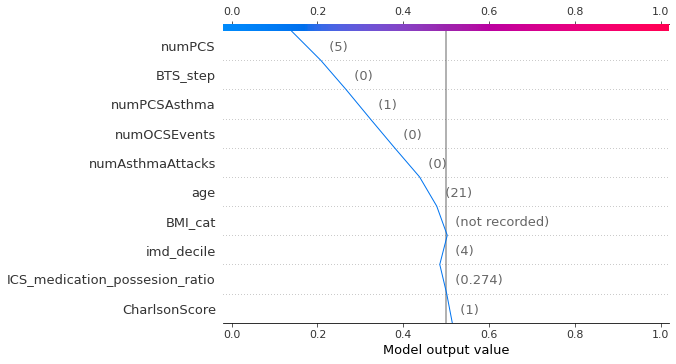

In [50]:
#TN
sample_id = 8
# shap.summary_plot(shap_values, X_externalVal_Ori, feature_names=X_externalVal.columns)
shap.decision_plot(explainer.expected_value, 
                   shap_values.values[sample_id], 
                   features = X_externalVal_Ori.iloc[sample_id], 
                   feature_display_range=slice(-1, -11, -1), #descending order
                   link="logit", )
shap.force_plot(explainer.expected_value, shap_values.values[sample_id], X_externalVal_Ori.iloc[sample_id], link='logit')

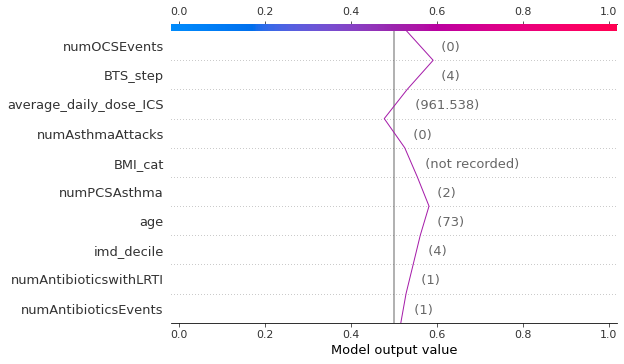

In [60]:
#FP
sample_id = 7
# shap.summary_plot(shap_values, X_externalVal_Ori, feature_names=X_externalVal.columns)
shap.decision_plot(explainer.expected_value, 
                   shap_values.values[sample_id], 
                   features = X_externalVal_Ori.iloc[sample_id], 
                   feature_display_range=slice(-1, -11, -1), #descending order
                   link="logit", )
shap.force_plot(explainer.expected_value, shap_values.values[sample_id], X_externalVal_Ori.iloc[sample_id], link='logit')

In [51]:
#true positive
y_externalVal[(y_externalVal.outcome_12months==1)&(y_externalVal.preds==1)].index[:5].tolist()

[39, 53, 54, 58, 88]

In [52]:
#false negative
y_externalVal[(y_externalVal.outcome_12months==1)&(y_externalVal.preds==0)].index[:5].tolist()

[75, 77, 92, 98, 120]

In [53]:
#true negative
y_externalVal[(y_externalVal.outcome_12months==0)&(y_externalVal.preds==0)].index[:5].tolist()

[0, 3, 4, 5, 8]

In [54]:
#false positive
y_externalVal[(y_externalVal.outcome_12months==0)&(y_externalVal.preds==1)].index[:5].tolist()

[1, 2, 6, 7, 16]

## LIME

In [ ]:
import lime
import lime.lime_tabular

In [ ]:
# LIME has one explainer for all the models
explainer = lime.lime_tabular.LimeTabularExplainer(X_externalVal.values, feature_names=X_externalVal.columns.values.tolist(),
                                                  verbose=True, mode='classification')

In [ ]:
j = 54
exp = explainer.explain_instance(X_externalVal.values[j], model.predict_proba, num_features=10)
# Show the predictions
exp.show_in_notebook(show_table=True)

In [ ]:
j = 75
exp = explainer.explain_instance(X_externalVal.values[j], model.predict_proba, num_features=10,)
# Show the predictions
exp.show_in_notebook(show_table=True)

In [ ]:
j = 0
exp = explainer.explain_instance(X_externalVal.values[j], model.predict_proba, num_features=10)
# Show the predictions
exp.show_in_notebook(show_table=True)

# Clinical utility

# Start HERE

In [72]:
# allData = pd.concat([gridSearchData, crossValData, internalEvaluationData, externalEvaluationData])
# allData.reset_index(drop=True, inplace=True)
externalEvaluationData = externalEvaluationData.merge(features[['patid', 'practice_id.x']], on = 'patid', how='inner')
externalEvaluationData.reset_index(drop=True, inplace=True)

In [73]:
def extract_event_rate(x):
    event_rate = externalEvaluationData[externalEvaluationData['practice_id.x']==x]['outcome_12months'].value_counts(normalize=True).tolist()
    if len(event_rate) > 1:
        return event_rate[1]
    else:
        return 0
practices = externalEvaluationData.groupby('practice_id.x').count()[['patid']]
practices['practice_id'] = practices.index
practices['practice_id'] = practices['practice_id'].apply(lambda x: int(x))
practices['event_rate'] = practices['practice_id'].apply(lambda x: extract_event_rate(x))
practices.reset_index(drop=True, inplace=True)
practices.rename(columns={'patid': 'n_patients'}, inplace=True)

<Axes: xlabel='n_patients', ylabel='event_rate'>

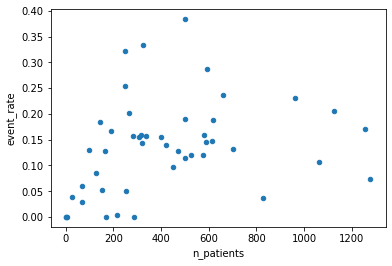

In [74]:
practices.plot.scatter(x='n_patients', y='event_rate')

In [75]:
practices[(practices['n_patients']>100) & ((practices['event_rate']>=.1) & (practices['event_rate']<.2))]

n_patients  practice_id  event_rate
0          617            6    0.188006
3          703          107    0.132290
7          499          188    0.190381
8         1065          208    0.107042
9          191          238    0.167539
12         308          411    0.155844
14         337          460    0.157270
18         146          506    0.184932
21         319          579    0.144201
22         165          751    0.127273
23         423          752    0.139480
28         615          821    0.147967
30         580          852    0.158621
31        1258          854    0.170111
32         316          911    0.158228
36         471          919    0.127389
37         501          973    0.113772
38         528         1060    0.121212
39         281         1064    0.156584
40         587         1066    0.144804
45         576         1116    0.119792
46         401         1126    0.154613

In [76]:
#practice selection
practice_ids = [913, 208, 1105] #with event rate <.1, 0.1-0.2, >0.2, respectively
capacity_percent = .5
output = []
for practice_id in practice_ids:
    print(f'practice id: {practice_id}')
    
    #PRIOR
    n = practices[practices.practice_id == practice_id]['n_patients'].tolist()[0]
    event_rate = practices[practices.practice_id == practice_id]['event_rate'].tolist()[0]
    high_risk_patients = int(np.round(n*event_rate))
    low_risk_patients = int(n - high_risk_patients)
    capacity = int(np.round(capacity_percent*n))
    print(f'Total people living with asthma: {n}')
    print(f'Event rate: {event_rate}')
    print(f'Number of patients with high risk of asthma attack: {high_risk_patients}')
    print(f'Number of patients with low risk of asthma attack: {low_risk_patients}')
    print(f'Total capacity of in-person asthma annual review: {capacity}')

    #Model prediction
    model = pickle.load(open('../../MODELS/TestResultOrdinal/outcome_12months_XGB.sav', 'rb'))
    calibrated_model = pickle.load(open('../../MODELS/CalibratedOrdinal/outcome_12months_XGB.sav', 'rb'))
    
    # best_model = pickle.load(open('../MODELS/TestResult/outcome_12months_XGB.sav', 'rb'))
    X_test = externalEvaluationData[externalEvaluationData['practice_id.x']==practice_id][features_columns]
    y_test = externalEvaluationData[externalEvaluationData['practice_id.x']==practice_id]['outcome_12months']
    
    step = .005 #how granular we want to have the plot
    thresholds = [round(i * step, 4) for i in range(int(1/step) + 1)]
    for threshold in thresholds:
        # print(threshold)
        preds = model.predict_proba(X_test)[:,1] #uncalibrated
        preds = calibrated_model.predict_proba(preds)  #calibrated
        preds = [1 if x >= threshold else 0 for x in preds]
        tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
        spec = tn /(tn+fp)
        sens = tp /(tp+fn)
        capacity_diff = (tp+fp)/capacity * 100
        output.append([practice_id, n, event_rate, threshold, tp, fp, tn, fn, spec, sens, capacity, capacity_diff])
    print("==================================================================================================")
print('done')

practice id: 913
Total people living with asthma: 828
Event rate: 0.036231884057971016
Number of patients with high risk of asthma attack: 30
Number of patients with low risk of asthma attack: 798
Total capacity of in-person asthma annual review: 414
[08:47:32] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 3
[08:47:32] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:822: [GPU Hist]: Configure
practice id: 208
Total people living with asthma: 1065
Event rate: 0.10704225352112676
Number of patients with high risk of asthma attack: 114
Number of patients with low risk of asthma attack: 951
Total capacity of in-person asthma annual review: 532
[08:48:01] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 3
[08:48:01] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:822: [GPU Hist]: Configure
practice id: 1105
Total people living with asthma: 503
Event rate: 0.3836978131212724
Number of patients with high risk of asthma attack: 193
Number of patients with low risk of ast

In [77]:
output = pd.DataFrame(output, columns=['practice', 'n', 'event_rate', 'threshold', 'TP', 'FP', 'TN', 'FN', 'SPEC', 'SENS', 'Capacity', 'CAP_DIFF'])
output.dropna(inplace=True)
output.drop_duplicates('CAP_DIFF', inplace=True)

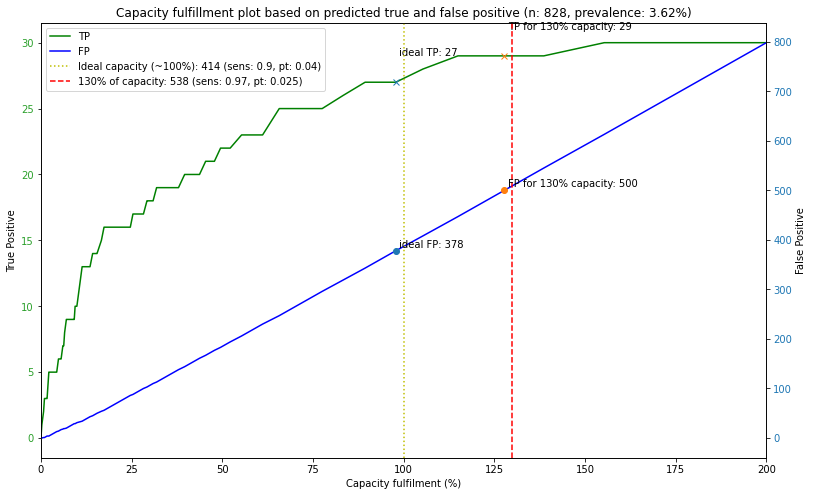

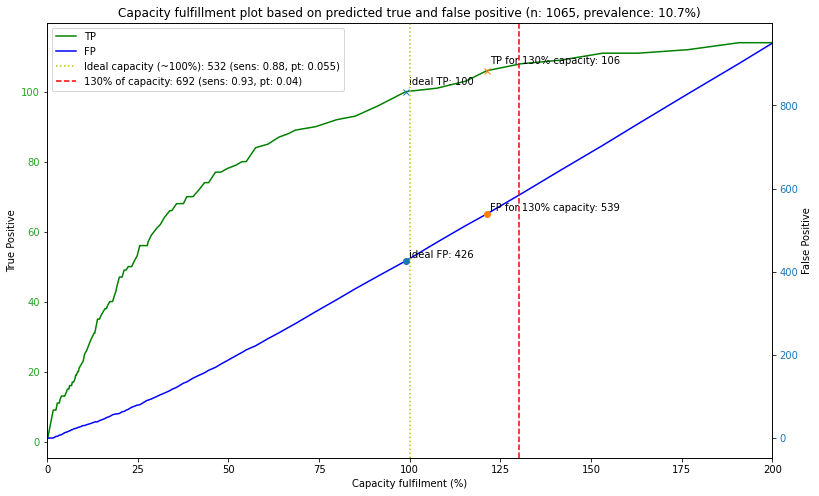

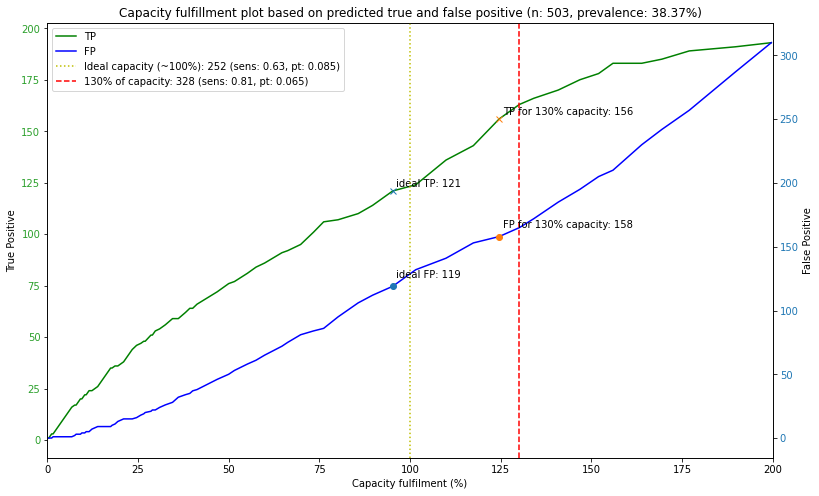

In [78]:
x = 'CAP_DIFF'
y_1 = 'TP'
y_2 = 'FP'
max_xlim = 200 #max % pf capacity to be plotted


for practice_id in practice_ids:
    data_output = output[output.practice == practice_id]
    fig, ax = plt.subplots(figsize=(13,8))
    data_output.plot(ax = ax, x=x, y=y_1, color='g', label=y_1)
    # ax.title.set_text('PM2.5 Design Values')
    ax.set_xlim(0,max_xlim)
    # ax.set_ylim(0,data_output[data_output.CAP_DIFF < max_xlim][y_2].values[0]) #set ylim based on the y2 value at CAP_DIFF ~ max_xlim
    # ax.set_ylim(0,data_output[y_1].max()) #set ylim based on the max value of y1
    ax.tick_params(axis='y', labelcolor='tab:green')
    ax.set_ylabel('True Positive')
    ax.set_xlabel('Capacity fulfilment (%)')
    
    # ax.set_xticks(IVdv.index)
    
    ax2=ax.twinx()
    ax2.plot(data_output[x], data_output[y_2], color='b', 
            label=y_2)
    
    # ax2.set_ylim(0,data_output[data_output.CAP_DIFF < max_xlim][y_2].values[0]) #set ylim based on the y2 value at CAP_DIFF ~ max_xlim
    # ax2.set_ylim(0,data_output[y_2].max()) #set ylim based on the max value of y2
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    ax2.set_ylabel('False Positive')

    #plot ideal capacity at 100%
    capacity = data_output.Capacity.values[0]
    x_mark = data_output[(data_output.CAP_DIFF <= 100)].CAP_DIFF.values[0]
    tp_mark = data_output[(data_output.CAP_DIFF == x_mark)].TP.values[0]
    fp_mark = data_output[(data_output.CAP_DIFF == x_mark)].FP.values[0]
    pt_mark = data_output[(data_output.CAP_DIFF == x_mark)].threshold.values[0]
    sens = np.round(data_output[(data_output.CAP_DIFF == x_mark)].SENS.values[0],2)

    ax2.axvline(x=100, color='y', label=f'Ideal capacity (~100%): {capacity} (sens: {sens}, pt: {pt_mark})', ls=':')
    ax.plot(x_mark, tp_mark, ls="", marker="x")
    ax.annotate("ideal TP: "+str(tp_mark), (x_mark+1, tp_mark+2))
    ax2.plot(x_mark, fp_mark, ls="", marker="o")
    ax2.annotate("ideal FP: "+str(fp_mark), (x_mark+1, fp_mark+7))
    # ax2.annotate(f"Ideal probability threshold: {pt_mark}")

    #plot capacity at 130%
    x_mark = data_output[(data_output.CAP_DIFF <= 130)].CAP_DIFF.values[0]
    tp_mark = data_output[(data_output.CAP_DIFF == x_mark)].TP.values[0]
    fp_mark = data_output[(data_output.CAP_DIFF == x_mark)].FP.values[0]
    pt_mark = data_output[(data_output.CAP_DIFF == x_mark)].threshold.values[0]
    sens = np.round(data_output[(data_output.CAP_DIFF == x_mark)].SENS.values[0],2)
    

    ax2.axvline(x=130, color='r', label=f'130% of capacity: {int(np.round(130/100*capacity))} (sens: {sens}, pt: {pt_mark})', ls='--')
    ax.plot(x_mark, tp_mark, ls="", marker="x")
    ax.annotate("TP for 130% capacity: "+str(tp_mark), (x_mark+1, tp_mark+2))
    ax2.plot(x_mark, fp_mark, ls="", marker="o")
    ax2.annotate("FP for 130% capacity: "+str(fp_mark), (x_mark+1, fp_mark+7))
    # ax2.annotate(f"Probability threshold fpr 130% capacity: {pt_mark}")
    
    
    lines_1, labels_1 = ax.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    
    ax.legend(lines, labels, loc='upper left')
    n = data_output.n.values[0]
    event_rate = np.round(data_output.event_rate.values[0]*100, 2)
    plt.title(f'Capacity fulfillment plot based on predicted true and false positive (n: {n}, prevalence: {event_rate}%)')
    # plt.legend()

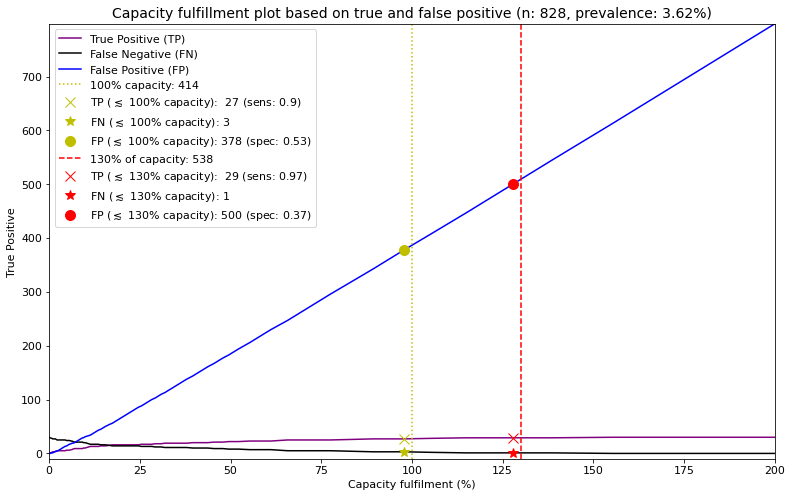

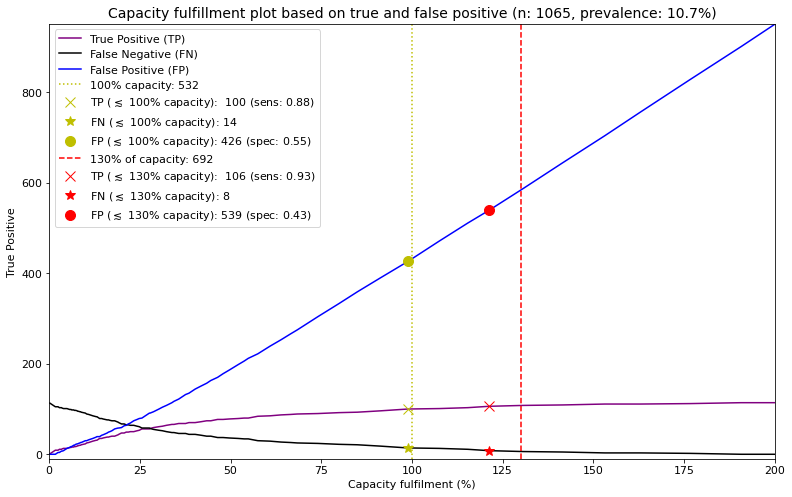

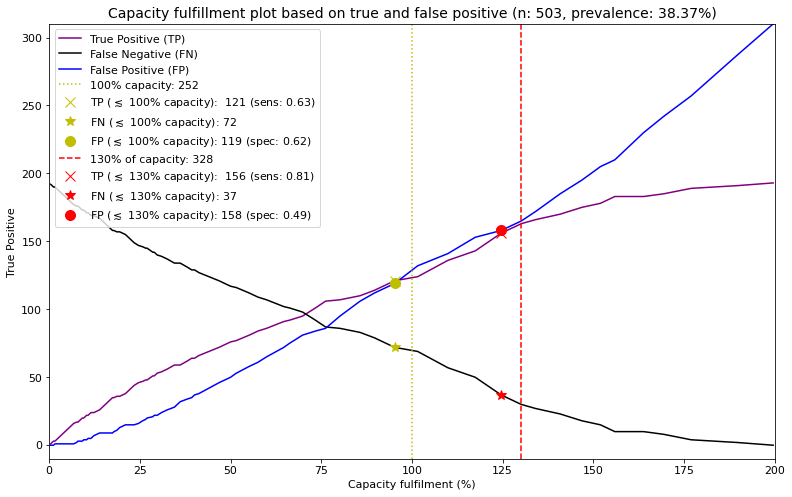

In [80]:
import matplotlib

SMALL_SIZE = 11
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)

x = 'CAP_DIFF'
y_1 = 'TP'
y_2 = 'FP'
y_3 = 'FN'
max_xlim = 200 #max % pf capacity to be plotted


for practice_id in practice_ids:
    data_output = output[output.practice == practice_id]
    fig, ax = plt.subplots(figsize=(13,8))
    data_output.plot(ax = ax, x=x, y=y_1, color='purple', label='True Positive (TP)')
    # ax.title.set_text('PM2.5 Design Values')
    ax.set_xlim(0,max_xlim)
    # ax.set_ylim(0,data_output[data_output.CAP_DIFF < max_xlim][y_2].values[0]) #set ylim based on the y2 value at CAP_DIFF ~ max_xlim
    ax.set_ylim(-10,data_output[y_2].max()) #set ylim based on the max value of y1
    # ax.tick_params(axis='y', labelcolor='tab:green')
    ax.set_ylabel('True Positive')
    ax.set_xlabel('Capacity fulfilment (%)')
    
    # ax.set_xticks(IVdv.index)
    
    # ax2=ax.twinx()
    ax.plot(data_output[x], data_output[y_3], color='black', 
            label='False Negative (FN)')
    
    ax.plot(data_output[x], data_output[y_2], color='b', 
            label='False Positive (FP)')
    
    # ax2.set_ylim(0,data_output[data_output.CAP_DIFF < max_xlim][y_2].values[0]) #set ylim based on the y2 value at CAP_DIFF ~ max_xlim
    # ax2.set_ylim(0,data_output[y_2].max()) #set ylim based on the max value of y2
    # ax2.tick_params(axis='y', labelcolor='tab:blue')
    # ax2.set_ylabel('False Positive')

    #plot ideal capacity at 100%
    capacity = data_output.Capacity.values[0]
    x_mark = data_output[(data_output.CAP_DIFF <= 100)].CAP_DIFF.values[0]
    tp_mark = data_output[(data_output.CAP_DIFF == x_mark)].TP.values[0]
    fp_mark = data_output[(data_output.CAP_DIFF == x_mark)].FP.values[0]
    fn_mark = data_output[(data_output.CAP_DIFF == x_mark)].FN.values[0]
    pt_mark = data_output[(data_output.CAP_DIFF == x_mark)].threshold.values[0]
    sens = np.round(data_output[(data_output.CAP_DIFF == x_mark)].SENS.values[0],2)
    spec = np.round(data_output[(data_output.CAP_DIFF == x_mark)].SPEC.values[0],2)

    ax.axvline(x=100, color='y', label=f'100% capacity: {capacity}', ls=':')
    ax.plot(x_mark, tp_mark, ls="", color='y', marker="x", markersize=10, label=r"TP ($ \lesssim $ 100% capacity): " + f" {tp_mark} (sens: {sens})")
    # ax.annotate(, (x_mark-50, tp_mark-30))
    ax.plot(x_mark, fn_mark, ls="", color='y', marker="*", markersize=10, label=r"FN ($ \lesssim $ 100% capacity): " + f"{fn_mark}")
    ax.plot(x_mark, fp_mark, ls="", color='y', marker="o", markersize=10, label=r"FP ($ \lesssim $ 100% capacity): " + f"{fp_mark} (spec: {spec})")
    
    # ax.annotate(, (x_mark-50, fp_mark+7))
    # ax2.annotate(f"Ideal probability threshold: {pt_mark}")

    #plot capacity at 130%
    x_mark = data_output[(data_output.CAP_DIFF <= 130)].CAP_DIFF.values[0]
    tp_mark = data_output[(data_output.CAP_DIFF == x_mark)].TP.values[0]
    fp_mark = data_output[(data_output.CAP_DIFF == x_mark)].FP.values[0]
    fn_mark = data_output[(data_output.CAP_DIFF == x_mark)].FN.values[0]
    pt_mark = data_output[(data_output.CAP_DIFF == x_mark)].threshold.values[0]
    sens = np.round(data_output[(data_output.CAP_DIFF == x_mark)].SENS.values[0],2)
    spec = np.round(data_output[(data_output.CAP_DIFF == x_mark)].SPEC.values[0],2)
    

    ax.axvline(x=130, color='r', label=f'130% of capacity: {int(np.round(130/100*capacity))}', ls='--')
    ax.plot(x_mark, tp_mark, ls="", marker="x", markersize=10, color='r', label=r"TP ($ \lesssim $ 130% capacity): " + f" {tp_mark} (sens: {sens})")
    # ax.annotate(, (x_mark+1, tp_mark-20))
    ax.plot(x_mark, fn_mark, ls="", color='r', marker="*", markersize=10, label=r"FN ($ \lesssim $ 130% capacity): " + f"{fn_mark}")
    ax.plot(x_mark, fp_mark, ls="", marker="o", markersize=10, color='r', label=r"FP ($ \lesssim $ 130% capacity): " + f"{fp_mark} (spec: {spec})")
    
    # ax.annotate(, (x_mark+1, fp_mark+7))
    # ax2.annotate(f"Probability threshold fpr 130% capacity: {pt_mark}")
    # plt.gca().set_yticks(np.arange(0, 1000, 100))
    
    lines_1, labels_1 = ax.get_legend_handles_labels()
    # lines_2, labels_2 = ax2.get_legend_handles_labels()
    
    lines = lines_1 
    labels = labels_1
    
    ax.legend(lines, labels, loc='upper left')
    n = data_output.n.values[0]
    event_rate = np.round(data_output.event_rate.values[0]*100, 2)
    plt.title(f'Capacity fulfillment plot based on true and false positive (n: {n}, prevalence: {event_rate}%)', fontsize=14)
    # plt.legend()

In [ ]:
allData.columns

In [ ]:
features_candidate = ['sex', 'age', 'BMI', 'ethnic_group', 'smokingStatus',
       'imd_decile', 'CharlsonScore', 'count_rhinitis', 'count_cardiovascular',
       'count_heartfailure', 'count_psoriasis', 'count_anaphylaxis',
       'count_diabetes', 'count_ihd', 'count_anxiety', 'count_eczema',
       'count_nasalpolyps', 'count_paracetamol', 'count_nsaids',
       'count_betablocker', 'PEFStatus', 'EosinophilLevel', 'BTS_step',
       'DeviceType', 'PriorEducation', 'average_daily_dose_ICS',
       'prescribed_daily_dose_ICS', 'ICS_medication_possesion_ratio', 'numPCS',
       'numPCSAsthma', 'numAntibioticsEvents', 'numAntibioticswithLRTI',
       'numOCSEvents', 'numOCSwithLRTI', 'numAsthmaAttacks',
       'numAcuteRespEvents', 'numHospEvents', 'numAsthmaManagement',
       'numAsthmaReview', 'numAsthmaMedReview', 'numAsthmaReviewRCP']
len(features_candidate)

In [ ]:
#onehot encoding for categorical variables
onehot_vars = ['BMI_cat', 'ethnic_group', 'smokingStatus', 'imd_decile', 'CharlsonScore',
               'PEFStatus', 'EosinophilLevel', 'BTS_step', 'DeviceType',  'PriorEducation',]
allData = pd.get_dummies(allData, columns=onehot_vars, dtype='int')
allData.columns

In [ ]:
#make sure get_dummies use 1 0 not true false
allData.iloc[:,80:]

In [ ]:
#Split training set into grid search, cross val, and internal validation

trainingData = allData[(allData.set == 'training')] #& (allData.age>=18)
gridSearchData, crossValData = train_test_split(trainingData, train_size=0.05, stratify=trainingData['outcome_12months'], random_state=random_state)
crossValData, internalEvaluationData = train_test_split(crossValData, test_size=0.215, stratify=crossValData['outcome_12months'],  random_state=random_state)
gridSearchData.reset_index(drop=True, inplace=True)
crossValData.reset_index(drop=True, inplace=True)
internalEvaluationData.reset_index(drop=True, inplace=True)

In [ ]:
#Proportion of asthma attack in each outcome - training

print('3 months -> ', round(gridSearchData['outcome_3months'].value_counts()[1]/len(gridSearchData)*100,2), '%')
print('6 months -> ', round(gridSearchData['outcome_6months'].value_counts()[1]/len(gridSearchData)*100,2), '%')
print('9 months -> ', round(gridSearchData['outcome_9months'].value_counts()[1]/len(gridSearchData)*100,2), '%')
print('12 months -> ', round(gridSearchData['outcome_12months'].value_counts()[1]/len(gridSearchData)*100,2), '%')
# print('3 months -> ', round(trainingData['outcome_3months'].value_counts()[1]/len(trainingData)*100,2), '%')
# print('6 months -> ', round(trainingData['outcome_combined_6months'].value_counts()[1]/len(trainingData)*100,2), '%')
# print('9 months -> ', round(trainingData['outcome_combined_9months'].value_counts()[1]/len(trainingData)*100,2), '%')
# print('12 months -> ', round(trainingData['outcome_combined_12months'].value_counts()[1]/len(trainingData)*100,2), '%')
# print('24 months -> ', round(trainingData['outcome_combined_24months'].value_counts()[1]/len(trainingData)*100,2), '%')

In [ ]:
#Proportion of asthma attack in each outcome - validation

print('3 months -> ', round(crossValData['outcome_3months'].value_counts()[1]/len(crossValData)*100,2), '%')
print('6 months -> ', round(crossValData['outcome_6months'].value_counts()[1]/len(crossValData)*100,2), '%')
print('9 months -> ', round(crossValData['outcome_9months'].value_counts()[1]/len(crossValData)*100,2), '%')
print('12 months -> ', round(crossValData['outcome_12months'].value_counts()[1]/len(crossValData)*100,2), '%')
# print('3 months -> ', round(validationData['outcome_3months'].value_counts()[1]/len(validationData)*100,2), '%')
# print('6 months -> ', round(validationData['outcome_combined_6months'].value_counts()[1]/len(validationData)*100,2), '%')
# print('9 months -> ', round(validationData['outcome_combined_9months'].value_counts()[1]/len(validationData)*100,2), '%')
# print('12 months -> ', round(validationData['outcome_combined_12months'].value_counts()[1]/len(validationData)*100,2), '%')
# print('24 months -> ', round(validationData['outcome_combined_24months'].value_counts()[1]/len(validationData)*100,2), '%')

In [ ]:
#Proportion of asthma attack in each outcome - internalEvaluation

print('3 months -> ', round(internalEvaluationData['outcome_3months'].value_counts()[1]/len(internalEvaluationData)*100,2), '%')
print('6 months -> ', round(internalEvaluationData['outcome_6months'].value_counts()[1]/len(internalEvaluationData)*100,2), '%')
print('9 months -> ', round(internalEvaluationData['outcome_9months'].value_counts()[1]/len(internalEvaluationData)*100,2), '%')
print('12 months -> ', round(internalEvaluationData['outcome_12months'].value_counts()[1]/len(internalEvaluationData)*100,2), '%')

In [ ]:
externalEvaluationData = allData[allData.set == 'evaluation']
externalEvaluationData = externalEvaluationData.drop_duplicates('patid')
externalEvaluationData.reset_index(drop=True, inplace=True)
print('size: ', externalEvaluationData.shape)
#Proportion of asthma attack in each outcome - internalEvaluation

print('3 months -> ', round(externalEvaluationData['outcome_3months'].value_counts()[1]/len(externalEvaluationData)*100,2), '%')
print('6 months -> ', round(externalEvaluationData['outcome_6months'].value_counts()[1]/len(externalEvaluationData)*100,2), '%')
print('9 months -> ', round(externalEvaluationData['outcome_9months'].value_counts()[1]/len(externalEvaluationData)*100,2), '%')
print('12 months -> ', round(externalEvaluationData['outcome_12months'].value_counts()[1]/len(externalEvaluationData)*100,2), '%')

In [ ]:
print(f'Grid search size: {gridSearchData.shape}')
print(f'Cross val size: {crossValData.shape}')
print(f'Internal val size: {internalEvaluationData.shape}')
print(f'External val size: {externalEvaluationData.shape}')

In [ ]:
#Save original data
# trainingData.to_csv('../FinalData/trainingData_2vs1_16112023.csv', index_label=False, index=False)
# validationData.to_csv('../FinalData/validationData_2vs1_16112023.csv', index_label=False, index=False)
# internalEvaluationData.to_csv('../FinalData/internalEvalulationData_2vs1_16112023.csv', index_label=False, index=False)
# evaluationData.to_csv('../FinalData/evaluationData_2vs1_16112023.csv', index_label=False, index=False)
# evaluationDataWales.to_csv('../FinalData/evaluationDataWales_2vs1_16112023.csv', index_label=False, index=False)
# evaluationDataScotland.to_csv('../FinalData/evaluationDataScotland_2vs1_16112023.csv', index_label=False, index=False)
sets = [gridSearchData, crossValData, internalEvaluationData, externalEvaluationData]
pickle.dump(sets, open('../Clean_data/dataset_2vs1_25102024.sav', 'wb'))

In [ ]:
# #encode categorical data
# # 
# # cat_vars = [, 'PEFStatus','EosinophilLevel']
# # data_categorical = trainingData[cat_vars]
# onehot_vars = ['ethnic_group','smokingStatus', 'DeviceType', 'cat_BMI', 'imd_decile', 'PEFStatus','EosinophilLevel', 'BTS_step']
# data_onehot = trainingData[onehot_vars]

# #ordinal encoder
# # encoder = OrdinalEncoder(categories=[['not_recorded','less than 60', '60-80', 'more than 80'], ['unknown', 'normal', 'high']]).set_output(transform="pandas")
# # data_encoded = encoder.fit_transform(data_categorical)
# # pickle.dump(encoder, open('../Models/cat_encoder.pkl', 'wb'))
    
# #one hot encoder
# onehot_encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
# onehot_encoded = onehot_encoder.fit_transform(data_onehot)
# pickle.dump(onehot_encoder, open('../Models/onehot_encoder.pkl', 'wb'))

# # trainingData = pd.concat([trainingData.drop(cat_vars, axis=1), data_encoded], axis=1)
# trainingData = pd.concat([trainingData.drop(onehot_vars, axis=1), onehot_encoded], axis=1)

# print('Data shape after encoding: ', trainingData.shape)

In [ ]:
# #encode cat vars for validation and evaluation set
# # data_val_categorical = validationData[cat_vars]
# data_val_onehot = validationData[onehot_vars]
# data_internaleval_onehot = internalEvaluationData[onehot_vars]
# # data_eval_categorical = evaluationData[cat_vars]
# data_eval_onehot = evaluationData[onehot_vars]
# # data_eval_Wales_categorical = evaluationDataWales[cat_vars]
# data_eval_Wales_onehot = evaluationDataWales[onehot_vars]
# # data_eval_Scotland_categorical = evaluationDataScotland[cat_vars]
# data_eval_Scotland_onehot = evaluationDataScotland[onehot_vars]

# # encoder = pickle.load(open('../Models/cat_encoder.pkl', 'rb'))
# # data_val_encoded = encoder.transform(data_val_categorical)
# # data_eval_encoded = encoder.transform(data_eval_categorical)
# # data_eval_Wales_encoded = encoder.transform(data_eval_Wales_categorical)
# # data_eval_Scotland_encoded = encoder.transform(data_eval_Scotland_categorical)

# onehot_encoder = pickle.load(open('../Models/onehot_encoder.pkl', 'rb'))
# onehot_val_encoded = onehot_encoder.transform(data_val_onehot)
# onehot_internaleval_encoded = onehot_encoder.transform(data_internaleval_onehot)
# onehot_eval_encoded = onehot_encoder.transform(data_eval_onehot)
# onehot_eval_Wales_encoded = onehot_encoder.transform(data_eval_Wales_onehot)
# onehot_eval_Scotland_encoded = onehot_encoder.transform(data_eval_Scotland_onehot)

# # validationData = pd.concat([validationData.drop(cat_vars, axis=1), data_val_encoded], axis=1)
# validationData = pd.concat([validationData.drop(onehot_vars, axis=1), onehot_val_encoded], axis=1)

# # evaluationData = pd.concat([evaluationData.drop(cat_vars, axis=1), data_eval_encoded], axis=1)
# internalEvaluationData = pd.concat([internalEvaluationData.drop(onehot_vars, axis=1), onehot_internaleval_encoded], axis=1)

# # evaluationData = pd.concat([evaluationData.drop(cat_vars, axis=1), data_eval_encoded], axis=1)
# evaluationData = pd.concat([evaluationData.drop(onehot_vars, axis=1), onehot_eval_encoded], axis=1)

# # evaluationDataWales = pd.concat([evaluationDataWales.drop(cat_vars, axis=1), data_eval_Wales_encoded], axis=1)
# evaluationDataWales = pd.concat([evaluationDataWales.drop(onehot_vars, axis=1), onehot_eval_Wales_encoded], axis=1)

# # evaluationDataScotland = pd.concat([evaluationDataScotland.drop(cat_vars, axis=1), data_eval_Scotland_encoded], axis=1)
# evaluationDataScotland = pd.concat([evaluationDataScotland.drop(onehot_vars, axis=1), onehot_eval_Scotland_encoded], axis=1)

# print('Val data shape after encoding: ', validationData.shape)
# print('Internal Eval data shape after encoding: ', internalEvaluationData.shape)
# print('Eval data shape after encoding: ', evaluationData.shape)
# print('Evaluation data Wales shape: ', evaluationDataWales.shape)
# print('Evaluation data Scotland shape: ', evaluationDataScotland.shape)

In [ ]:
# Cont Var Scalling

In [ ]:
allData.columns.values

In [ ]:
continuous_vars = ['age', 'average_daily_dose_ICS', 'prescribed_daily_dose_ICS',
                   'ICS_medication_possesion_ratio', 'numPCS', 'numPCSAsthma',
                   'numAntibioticsEvents', 'numAntibioticswithLRTI', 'numOCSEvents',
                   'numOCSwithLRTI', 'numAsthmaAttacks', 'numAcuteRespEvents',
                   'numHospEvents', 'numAsthmaManagement', 'numAsthmaReview',
                   'numAsthmaMedReview', 'numAsthmaReviewRCP',]
len(continuous_vars)

In [ ]:
#Data normalisation for continous variable into 0-1 range based on gridSearch set

# define scaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(gridSearchData[continuous_vars])
pickle.dump(scaler, open('../Models/cont_scaler.pkl', 'wb'))


data_scaled = pd.DataFrame(data_scaled, columns=scaler.get_feature_names_out())
gridSearchData = pd.concat([gridSearchData.drop(continuous_vars, axis=1), data_scaled], axis=1)

print('Data shape after scaling: ', gridSearchData.shape)

In [ ]:
#Normalisation for other sets

scaler = pickle.load(open('../Models/cont_scaler.pkl', 'rb'))
data_val_scaled = scaler.transform(crossValData[continuous_vars])
data_internal_eval_scaled = scaler.transform(internalEvaluationData[continuous_vars])
data_external_eval_scaled = scaler.transform(externalEvaluationData[continuous_vars])

data_val_scaled = pd.DataFrame(data_val_scaled, columns=scaler.get_feature_names_out())
crossValData = pd.concat([crossValData.drop(continuous_vars, axis=1), data_val_scaled], axis=1)

data_internal_eval_scaled = pd.DataFrame(data_internal_eval_scaled, columns=scaler.get_feature_names_out())
internalEvaluationData = pd.concat([internalEvaluationData.drop(continuous_vars, axis=1), data_internal_eval_scaled], axis=1)

data_external_eval_scaled = pd.DataFrame(data_external_eval_scaled, columns=scaler.get_feature_names_out())
externalEvaluationData = pd.concat([externalEvaluationData.drop(continuous_vars, axis=1), data_external_eval_scaled], axis=1)


print('Val data shape after scaling: ', crossValData.shape)
print('Eval data shape after scaling: ', internalEvaluationData.shape)
print('Evaluation data Wales shape: ', externalEvaluationData.shape)

In [ ]:
#Define feature candidates

features_columns = gridSearchData.columns.to_list()
exclude_columns = ['patid', 'practice_id', 'set', #identifier
                   'BMI', #use the categorical instead
                   'ethnicity', #use ethnic_group instead
                   'Spacer',  #all zero
                   
                   'outcome_3months', 'outcome_6months', 'outcome_9months', 'outcome_12months', 'outcome_15months', 'outcome_18months', 
                   'outcome_21months', 'outcome_24months', 'outcome_combined_6months', 'outcome_combined_9months', 'outcome_combined_12months', 
                   'outcome_combined_15months', 'outcome_combined_18months', 'outcome_combined_24months', '3months', '6months', '12months', '24months', #outcomes variable
                   
                   'postcode_district', 'County', 'LocalAuthority', 'OutputAreaClassification', #location related variables, use IMD decile only
                   
                   'age_cat', 'ICS_medication_possesion_ratio_cat', 'numOCS_cat', 'numOCSEvents_cat', 'numOCSwithLRTI_cat', 'numAcuteRespEvents_cat', 
                   'numAntibioticsEvents_cat', 'numAntibioticswithLRTI_cat', 'numAsthmaAttacks_cat', 'numHospEvents_cat', 'numPCS_cat', 'numPCSAsthma_cat', 
                   'numAsthmaManagement_cat', 'numAsthmaReview_cat', 'numAsthmaMedReview_cat', 'numAsthmaReviewRCP_cat', 'average_daily_dose_ICS_cat', 
                   'prescribed_daily_dose_ICS_cat', #use continous vars instead
                   
                   'count_rhinitis', 'count_cardiovascular', 'count_heartfailure',
                   'count_psoriasis', 'count_anaphylaxis', 'count_diabetes', 'count_ihd',
                   'count_anxiety', 'count_eczema', 'count_nasalpolyps',
                   'count_paracetamol', 'count_nsaids', 'count_betablocker', #use binary ones
                   
                   'paracetamol', 'nsaids', 'betablocker', #no data in evaluation
                                      
                  ]
# exclude_columns = exclude_columns + [x for x in features_columns if '_count' in x] #filter out commorbid count variables
features_columns = [x for x in features_columns if x not in exclude_columns]
print('Features size: ', len(features_columns))
print(features_columns)

In [ ]:
#make sure no data leak between sets
print(list(set(gridSearchData.patid.values).intersection(set(crossValData.patid.values))))
print(list(set(gridSearchData.patid.values).intersection(set(internalEvaluationData.patid.values))))
print(list(set(crossValData.patid.values).intersection(set(internalEvaluationData.patid.values))))
print(list(set(crossValData.patid.values).intersection(set(externalEvaluationData.patid.values))))
print(list(set(gridSearchData.patid.values).intersection(set(externalEvaluationData.patid.values))))


In [ ]:
#Save encoded data
# trainingData.to_csv('../FinalData/trainingDataEncoded_2vs1_16112023.csv', index_label=False, index=False)
# validationData.to_csv('../FinalData/validationDataEncoded_2vs1_16112023.csv', index_label=False, index=False)
# internalEvaluationData.to_csv('../FinalData/internalEvaluationDataEncoded_2vs1_16112023.csv', index_label=False, index=False)
# evaluationData.to_csv('../FinalData/evaluationDataEncoded_2vs1_16112023.csv', index_label=False, index=False)
# evaluationDataWales.to_csv('../FinalData/evaluationDataWalesEncoded_2vs1_16112023.csv', index_label=False, index=False)
# evaluationDataScotland.to_csv('../FinalData/evaluationDataScotlandEncoded_2vs1_16112023.csv', index_label=False, index=False)
sets = [gridSearchData, crossValData, internalEvaluationData, externalEvaluationData]
pickle.dump(sets, open('../Clean_data/dataset_scaled_2vs1_25102024.sav', 'wb'))